In [1]:
import json
import os
import time
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import train_test_split

from model_pytorch import EfficientNet
from utils import Bar,Logger, AverageMeter, accuracy, mkdir_p, savefig
from warmup_scheduler import GradualWarmupScheduler

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import collections

# Arguments

In [2]:
data_dir = '/media/data2/dataset/GAN_ImageData/StyleGAN_256/'

In [3]:
pretrained = ''
resume = ''

In [4]:
# Model
model_name = 'efficientnet-b0' # b0-b7 scale

# Optimization
num_classes = 2
epochs = 400
start_epoch = 0
train_batch = 256
test_batch = 200
lr = 0.04
schedule = [150, 275]
momentum = 0.9
gamma = 0.1 # LR is multiplied by gamma on schedule

# CheckPoint
checkpoint = './log/style1/' # dir
if not os.path.isdir(checkpoint):
    os.mkdir(checkpoint)
num_workers = 4

# Seed
manual_seed = 7
random.seed(manual_seed)
torch.cuda.manual_seed_all(manual_seed)

# Image
size = (128, 128)

best_acc = 0

In [5]:
state = {}
state['num_classes'] = num_classes
state['epochs'] = epochs
state['start_epoch'] = start_epoch
state['train_batch'] = train_batch
state['test_batch'] = test_batch
state['lr'] = lr
state['schedule'] = schedule
state['momentum'] = momentum
state['gamma'] = gamma

In [6]:
# GPU Device
gpu_id = 3
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
use_cuda = torch.cuda.is_available()
print("GPU device %d:" %(gpu_id), use_cuda)

GPU device 3: True


# Dataset

In [7]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')    
train_aug = transforms.Compose([
    transforms.RandomAffine(degrees=2, translate=(0.02, 0.02), scale=(0.98, 1.02), shear=2, fillcolor=(124,117,104)),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.10), ratio=(0.3, 3.3), value=0, inplace=True),
])
val_aug = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
])

# pin_memory : cuda pin memeory use
train_loader = DataLoader(datasets.ImageFolder(train_dir, transform=train_aug),
                          batch_size=train_batch, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(datasets.ImageFolder(val_dir, val_aug),
                       batch_size=test_batch, shuffle=True, num_workers=num_workers, pin_memory=True)

In [8]:
for i,j in train_loader:
    break

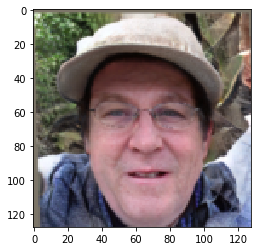

In [20]:
plt.imshow(i[6].numpy().transpose((1, 2, 0)))

In [19]:
j

tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0])

# Model

In [9]:
model = EfficientNet.from_name(model_name, num_classes=num_classes, override_params={'dropout_rate':0.0})

# Pre-trained
if pretrained:
    print("=> using pre-trained model '{}'".format(pretrained))
    model.load_state_dict(torch.load(pretrained)['state_dict'])

In [10]:
model.to('cuda')
cudnn.benchmark = True
print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    Total params: 4.01M


In [10]:
# summary(model, input_size=(3,64,64), device='cuda')

# Loss

In [12]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4, nesterov=True)
# optimizer = optim.Adam(model.parameters(), weight_decay=0)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=8, total_epoch=10, after_scheduler=scheduler_cosine)

In [13]:
# Resume
if resume:
    print('==> Resuming from checkpoint..')
    checkpoint = os.path.dirname(resume)
#     checkpoint = torch.load(resume)
    resume = torch.load(resume)
    best_acc = resume['best_acc']
    start_epoch = resume['epoch']
    model.load_state_dict(resume['state_dict'])
    optimizer.load_state_dict(resume['optimizer'])
    logger = Logger(os.path.join(checkpoint, 'log.txt'), resume=True)
else:
    logger = Logger(os.path.join(checkpoint, 'log.txt'))
    logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])

# Train

In [14]:
def train(train_loader, model, criterion, optimizer, epoch, use_cuda):
    model.train()
    torch.set_grad_enabled(True)
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    end = time.time()
    
    bar = Bar('Processing', max=len(train_loader))
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        batch_size = inputs.size(0)
        if batch_size < train_batch:
            continue
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1 = accuracy(outputs.data, targets.data)
        losses.update(loss.data.tolist(), inputs.size(0))
        top1.update(prec1[0], inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=batch_idx + 1,
                    size=len(train_loader),
                    data=data_time.val,
                    bt=batch_time.val,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    top1=top1.avg,
                    )
        bar.next()
        if batch_idx % 10 == 0:
            print('{batch}/{size} Data:{data:.3f} | Batch:{bt:.3f} | Total:{total:} | ETA:{eta:} | Loss:{loss:} | top1:{tp1:}'.format(
                 batch=batch_idx+1, size=len(train_loader), data=data_time.val, bt=batch_time.val, total=bar.elapsed_td, eta=bar.eta_td, loss=losses.avg, tp1=top1.avg))
    bar.finish()
    return (losses.avg, top1.avg)

In [15]:
def test(val_loader, model, criterion, epoch, use_cuda):
    global best_acc

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    torch.set_grad_enabled(False)

    end = time.time()
    bar = Bar('Processing', max=len(val_loader))
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1 = accuracy(outputs.data, targets.data)
        losses.update(loss.data.tolist(), inputs.size(0))
        top1.update(prec1[0], inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:} | top1: {top1:}'.format(
                    batch=batch_idx + 1,
                    size=len(val_loader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    top1=top1.avg,)
        bar.next()
    print('{batch}/{size} Data:{data:.3f} | Batch:{bt:.3f} | Total:{total:} | ETA:{eta:} | Loss:{loss:} | top1:{tp1:}'.format(
         batch=batch_idx+1, size=len(val_loader), data=data_time.val, bt=batch_time.val, total=bar.elapsed_td, eta=bar.eta_td, loss=losses.avg, tp1=top1.avg))
    bar.finish()
    return (losses.avg, top1.avg)

In [16]:
def save_checkpoint(state, is_best, checkpoint='checkpoint', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_best.pth.tar'))

def adjust_learning_rate(optimizer, epoch):
    global state
    if epoch in schedule:
        state['lr'] *= gamma
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']

In [ ]:
for epoch in range(start_epoch, epochs):
    adjust_learning_rate(optimizer, epoch)
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    state['lr'] = lr
    print('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, epochs, state['lr']))
    
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, use_cuda)
    test_loss, test_acc = test(val_loader, model, criterion, epoch, use_cuda)
    
    logger.append([state['lr'], train_loss, test_loss, train_acc, test_acc])
    scheduler_warmup.step()

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict' : model.state_dict(),
        'acc': test_acc,
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }, is_best, checkpoint=checkpoint)


Epoch: [1 | 400] LR: 0.040000
1/269 Data:3.659 | Batch:8.118 | Total:0:00:08 | ETA:0:36:16 | Loss:0.6927245259284973 | top1:53.515625
11/269 Data:0.003 | Batch:0.505 | Total:0:00:13 | ETA:0:05:47 | Loss:0.7046850594607267 | top1:50.7457389831543
21/269 Data:0.003 | Batch:0.566 | Total:0:00:19 | ETA:0:02:22 | Loss:0.8049656095958891 | top1:50.42782974243164
31/269 Data:0.004 | Batch:0.662 | Total:0:00:28 | ETA:0:03:30 | Loss:0.7856161594390869 | top1:50.02519989013672
41/269 Data:0.002 | Batch:0.658 | Total:0:00:36 | ETA:0:03:02 | Loss:0.765358823101695 | top1:50.11432647705078
51/269 Data:0.001 | Batch:0.567 | Total:0:00:43 | ETA:0:02:24 | Loss:0.7515898942947388 | top1:50.32935333251953
61/269 Data:0.079 | Batch:0.642 | Total:0:00:50 | ETA:0:02:44 | Loss:0.7471849937907985 | top1:50.384220123291016
71/269 Data:0.006 | Batch:0.689 | Total:0:01:02 | ETA:0:03:44 | Loss:0.7412598401727811 | top1:50.39612579345703
81/269 Data:0.001 | Batch:0.552 | Total:0:01:11 | ETA:0:02:47 | Loss:0.7377